In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models,Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical
import seaborn as sns

In [2]:
IMG_SIZE = 71
Channel=3
Epochs=20
Batch_size=32
no_classes=12

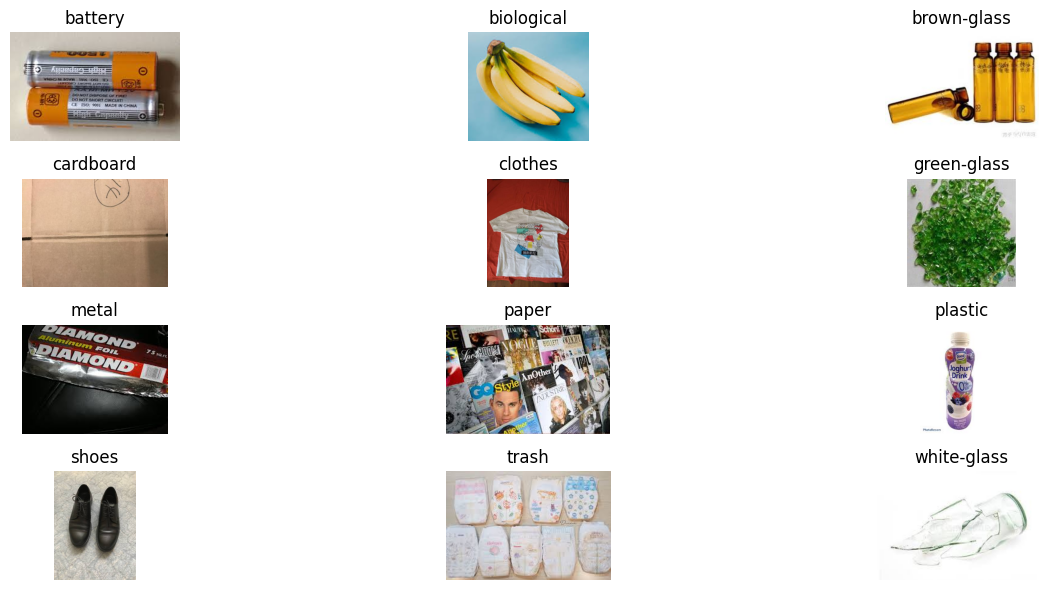

In [3]:
DATADIR = 'D:\garbage_classification'  # Ensure this path is correct
CATEGORIES = ["battery", "biological","brown-glass", "cardboard", "clothes", "green-glass",
              "metal", "paper", "plastic", "shoes", "trash","white-glass"]
#CATEGORIES = ["cardboard","glass","metal","paper","plastic","trash"]
# Set up the plotting
fig, axes = plt.subplots(4, 3, figsize=(15, 6))  # 2 rows, 5 columns for images
axes = axes.ravel()  # Flatten the axes array for easier indexing

# Loop over categories and display the first RGB image with its label
for i, category in enumerate(CATEGORIES): 
    path = os.path.join(DATADIR, category)
    img = os.listdir(path)[0]  # Get the first image from the category
    img_array = cv2.imread(os.path.join(path, img))  # Read the image in RGB
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct colors

    axes[i].imshow(img_array)  # Display the image
    axes[i].set_title(category)  # Add label (category) under the image
    axes[i].axis('off')  # Hide axes for better visual

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [4]:
print(img_array)
print(img_array.shape)

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
(177, 285, 3)


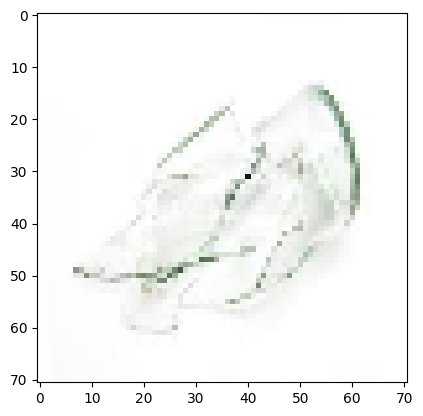

In [5]:
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array)
plt.show()

In [6]:
# Preparing the training data
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)  # Create path for the category
        class_num = CATEGORIES.index(category)  # Get the class label
        for img_name in tqdm(os.listdir(path), desc=f"Processing {category}"):  # Iterate over each image
            try:
                img_path = os.path.join(path, img_name)
                img_array = cv2.imread(img_path)  # Read image
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)  # Convert to RGB
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # Resize
                training_data.append([new_array, class_num])  # Add to training data
            except Exception as e:
                print(f"Error processing image {img_name} in {category}: {e}")

create_training_data()
print(f"Total training samples: {len(training_data)}")

Processing white-glass: 100%|██████████| 775/775 [00:00<00:00, 1064.12it/s]

Total training samples: 15515


In [7]:
random.shuffle(training_data)
for sample in training_data[:10]:
    print(sample[1])

4
4
4
7
2
6
7
10
4
9


In [8]:
X = []
y = []

# Loop through training data
for features, label in training_data:
    X.append(features)
    y.append(label)

# Convert lists to numpy arrays
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE,Channel)  # Adjust shape for RGB images
X = X / 255  # Normalize pixel values
y = np.array(y)

In [9]:
print(X)
print(X.shape)

[[[[0.28235294 0.0627451  0.10588235]
   [0.32156863 0.08627451 0.13333333]
   [0.33333333 0.08627451 0.14117647]
   ...
   [0.39607843 0.09803922 0.16862745]
   [0.39607843 0.10980392 0.17647059]
   [0.36862745 0.09803922 0.15686275]]

  [[0.32156863 0.08627451 0.13333333]
   [0.34509804 0.09411765 0.14901961]
   [0.36862745 0.10196078 0.16078431]
   ...
   [0.43921569 0.12156863 0.19607843]
   [0.43921569 0.12941176 0.20392157]
   [0.39607843 0.10588235 0.17254902]]

  [[0.34509804 0.09411765 0.14901961]
   [0.38823529 0.09803922 0.16470588]
   [0.38039216 0.10588235 0.16862745]
   ...
   [0.43921569 0.11372549 0.18431373]
   [0.45098039 0.1254902  0.19607843]
   [0.43529412 0.10980392 0.18039216]]

  ...

  [[0.51372549 0.15686275 0.27843137]
   [0.55294118 0.18039216 0.30588235]
   [0.56470588 0.18431373 0.31372549]
   ...
   [0.63137255 0.22352941 0.35294118]
   [0.62352941 0.21568627 0.34509804]
   [0.59607843 0.18431373 0.31764706]]

  [[0.47843137 0.14117647 0.25490196]
   [0.5

In [10]:
base_model=keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(71,71,3),
    pooling=None,
    classes=12,
    classifier_activation="softmax",
)

In [11]:
base_model.trainable = False

In [12]:
# Add custom layers on top of the base model
model=models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128,"relu"))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.Dense(12, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 128)               3

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [14]:
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
history=model.fit(X_train, y_train, epochs=20, batch_size=32,validation_split=0.2,callbacks=[early_stopping])

Epoch 1/20
311/311 [==============================] - 16s 28ms/step - loss: 1.2188 - accuracy: 0.6242 - val_loss: 0.7851 - val_accuracy: 0.7624
Epoch 2/20
311/311 [==============================] - 7s 23ms/step - loss: 0.8797 - accuracy: 0.7227 - val_loss: 0.6934 - val_accuracy: 0.7870
Epoch 3/20
311/311 [==============================] - 7s 23ms/step - loss: 0.7685 - accuracy: 0.7558 - val_loss: 0.6650 - val_accuracy: 0.7902
Epoch 4/20
311/311 [==============================] - 7s 23ms/step - loss: 0.7023 - accuracy: 0.7770 - val_loss: 0.6489 - val_accuracy: 0.7978
Epoch 5/20
311/311 [==============================] - 7s 22ms/step - loss: 0.6555 - accuracy: 0.7940 - val_loss: 0.6699 - val_accuracy: 0.8010
Epoch 6/20
311/311 [==============================] - 7s 23ms/step - loss: 0.6258 - accuracy: 0.7987 - val_loss: 0.6233 - val_accuracy: 0.8099
Epoch 7/20
311/311 [==============================] - 7s 23ms/step - loss: 0.5805 - accuracy: 0.8105 - val_loss: 0.6021 - val_accuracy: 0.820

In [17]:
test_loss, test_acc = model.evaluate(X_test,y_test)
test_acc

97/97 [==============================] - 2s 18ms/step - loss: 0.5666 - accuracy: 0.8173


0.8172736167907715

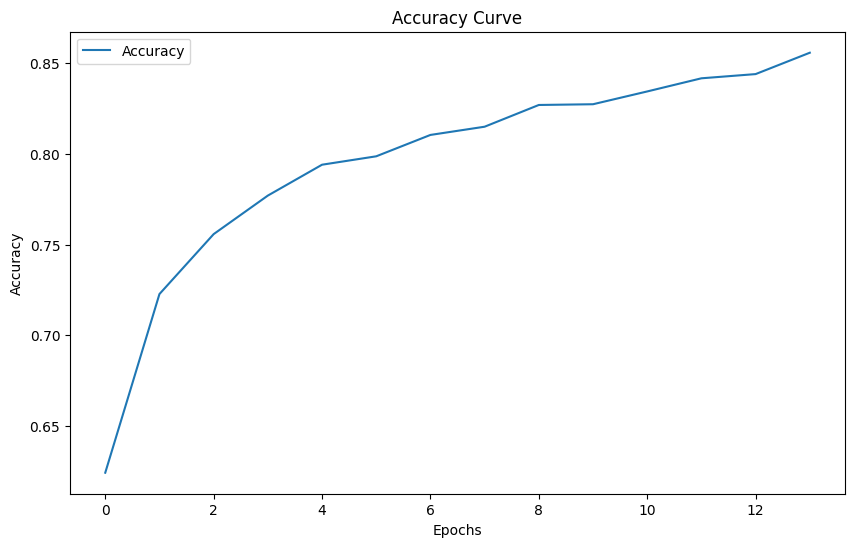

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

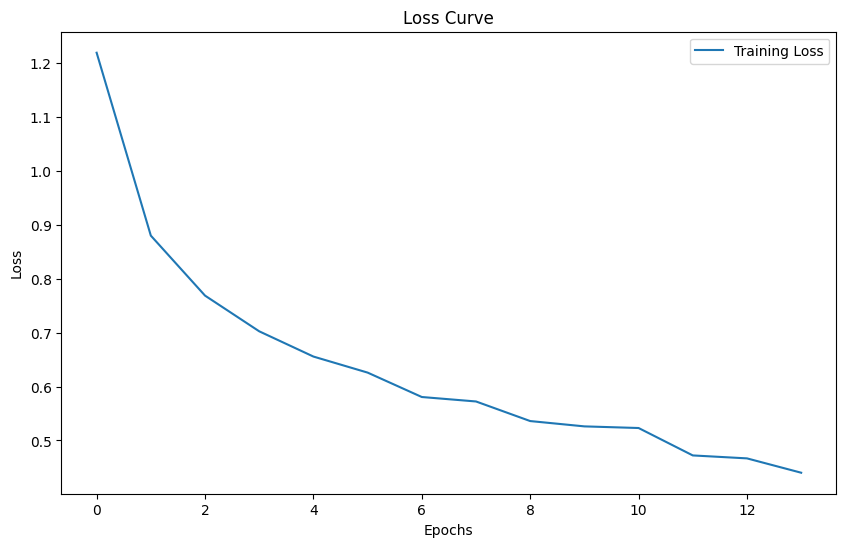

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

In [20]:
'''
from tensorflow.keras.models import load_model
# Specify the path to the saved model file
model_path = 'Xception.keras'
# Load the model
model = load_model(model_path)
'''

"\nfrom tensorflow.keras.models import load_model\n# Specify the path to the saved model file\nmodel_path = 'Xception.keras'\n# Load the model\nmodel = load_model(model_path)\n"

97/97 [==============================] - 2s 14ms/step


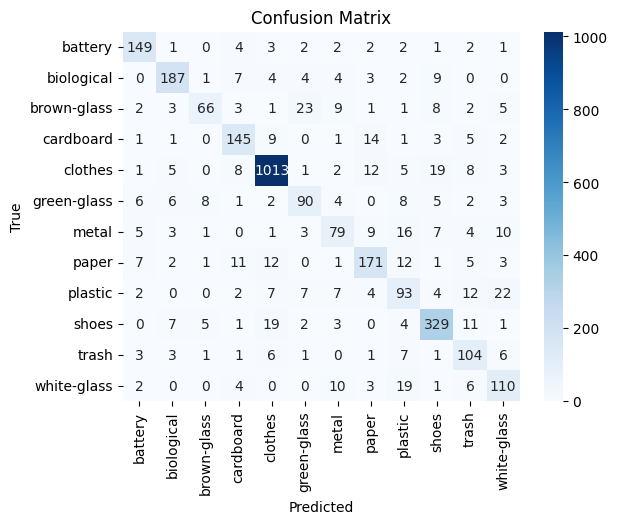

In [21]:
y_pred = np.argmax(model.predict(X_test), axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')  # 'macro' for multiclass
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=CATEGORIES))

# Display metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Classification Report:
              precision    recall  f1-score   support

     battery       0.84      0.88      0.86       169
  biological       0.86      0.85      0.85       221
 brown-glass       0.80      0.53      0.64       124
   cardboard       0.78      0.80      0.79       182
     clothes       0.94      0.94      0.94      1077
 green-glass       0.68      0.67      0.67       135
       metal       0.65      0.57      0.61       138
       paper       0.78      0.76      0.77       226
     plastic       0.55      0.58      0.56       160
       shoes       0.85      0.86      0.85       382
       trash       0.65      0.78      0.71       134
 white-glass       0.66      0.71      0.69       155

    accuracy                           0.82      3103
   macro avg       0.75      0.74      0.74      3103
weighted avg       0.82      0.82      0.82      3103

Accuracy: 0.82
Precision: 0.75
Recall: 0.74
F1-Score: 0.74


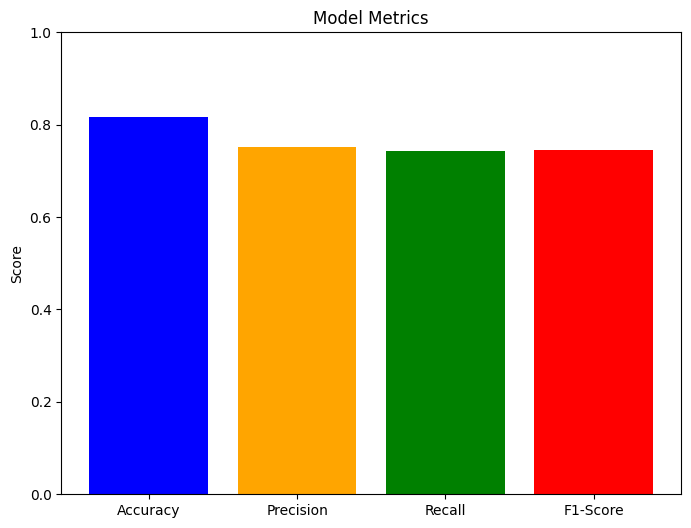

In [23]:
# Bar chart for metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'orange', 'green', 'red'])
plt.ylim(0, 1)
plt.title('Model Metrics')
plt.ylabel('Score')
plt.show()

97/97 [==============================] - 1s 14ms/step


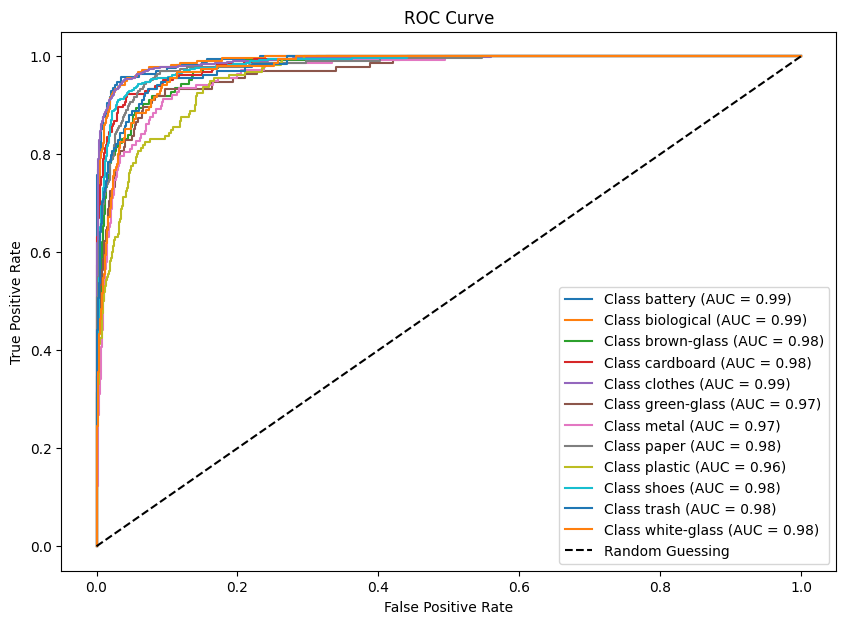

In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

y_test_bin = to_categorical(y_test, num_classes=len(CATEGORIES))
y_pred_proba = model.predict(X_test)  

plt.figure(figsize=(10, 7))
for i in range(len(CATEGORIES)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {CATEGORIES[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

97/97 [==============================] - 1s 14ms/step
Predicted category: paper
True category: paper


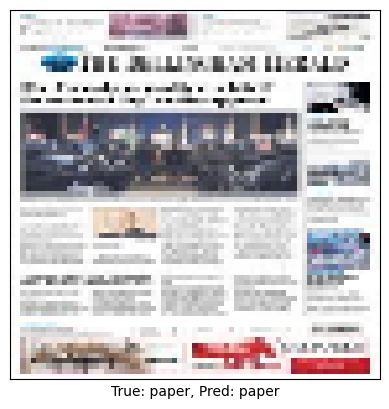

In [25]:
item =200  # The index of the image to display
predictions = model.predict(X_test)  # Get predictions for x_test
predicted_label = np.argmax(predictions[item])  # Get the predicted class label (index)
true_label = y_test[item]  # Get the true label for the item (index)

# Convert the numerical indices to category names
predicted_category = CATEGORIES[predicted_label]
true_category = CATEGORIES[true_label]

# Print the predicted and true categories
print(f"Predicted category: {predicted_category}")
print(f"True category: {true_category}")

# Display the image
plt.imshow(X_test[item])  # Display the RGB image (no colormap needed)
plt.xticks([])  # Hide x-axis ticks
plt.yticks([])  # Hide y-axis ticks
plt.xlabel(f"True: {true_category}, Pred: {predicted_category}")  # Show category names
plt.show()

In [43]:
from tensorflow.keras.preprocessing import image
from pathlib import Path

def preprocess_image(image_path):
    try:
        # Load the image, resize to 32x32 and convert to RGB format
        img = image.load_img(image_path, target_size=(71, 71))  # Resize to 32x32
        # Convert the image to a numpy array and normalize it
        img_array = image.img_to_array(img) / 255  # Normalize to [0, 1]
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (1, 32, 32, 3)
        return img_array
    except Exception as e:
        print(f"Error during preprocessing: {e}")
        return None

# Path to the external image (use pathlib for better path handling)
image_path = Path("D:\\Deep_project\\Test_Images\\clothes320.jpg")

# Preprocess the external image
preprocessed_image = preprocess_image(image_path)

if preprocessed_image is not None:
    print("Image preprocessed successfully!")
else:
    print("Failed to preprocess the image.")


Image preprocessed successfully!


1/1 [==============================] - 0s 29ms/step


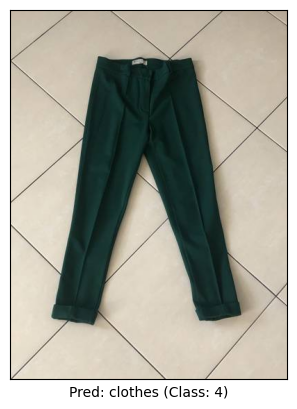

In [44]:
CATEGORIES = ["battery", "biological","brown-glass", "cardboard", "clothes", "green-glass",
              "metal", "paper", "plastic", "shoes", "trash","white-glass"]
# Get the prediction for the image
predictions = model.predict(preprocessed_image)
predicted_label = np.argmax(predictions)  # Get the predicted class label (index)

# Display the image
img = image.load_img(image_path)  # Reload the image to show it
plt.imshow(img)  # Display the RGB image
plt.xticks([])  # Hide x-axis ticks
plt.yticks([])  # Hide y-axis ticks
plt.xlabel(f"Pred: {CATEGORIES[predicted_label]} (Class: {predicted_label})")
plt.show()


In [28]:
#model.save("Xception.keras")